# Feature Engineering + Sanity Check on Data


In this notebook,after we have cleaned that data, we will work on feature engineering. This notebook might be revisited during model evaluation to improve our clustering problem

As much as I believe we will probably resort to deep learning, but feature engineering will be done based on K-means clustering assumptions 

In this notebook, we will do the following:
* Deal with categorical data sperately 
* Deal with numeric data seperately 
* Data-specific transformations 
* make sure everything was done correctly in the cleaning process
* a simple attempt of clustering 

In [1]:
##imports 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy 
import scipy.stats as stats 
import sklearn.preprocessing as preprocess 
import sklearn.cluster as cluster 
import sklearn.feature_selection as feature_selection
import feature_engine as fe

## 0 Getting the data ready:

In [2]:
# we will pool all the dataframes first before 
import os
os.listdir()

['cleaned_clusterd.csv',
 'mos_symp.xlsx',
 'Improving Clustering prep 3.ipynb',
 'other_symp_dummies.xlsx',
 'data_pooled_cleaned.csv',
 'Data Cleaning .ipynb',
 'Improving Clustering and Experimenting 3.ipynb',
 'covid.xlsx',
 '.DS_Store',
 'phq_symp.xlsx',
 'treatment_related_dummies.xlsx',
 'covid_dummies_new.xlsx',
 'checkpoint_final_depaul_scored.csv',
 'Improving Clustering and Experimenting 2.ipynb',
 'Long covid_ Data collection - Google Forms.pdf',
 'Improving Clustering and Experimenting 4.ipynb',
 'treatment_related.xlsx',
 'Data collection sheet.pdf',
 'Baseline Clustering .ipynb',
 'Feature Engineering .ipynb',
 'Long_covid_original(not cleaned).xlsx',
 'Improving Clustering and Experimenting.ipynb',
 'cleaned_clusterd_new.csv',
 'Supplementary .ipynb',
 'covid_dummies.xlsx',
 '.ipynb_checkpoints',
 'cleaned_clusterd_depaul_added.csv',
 'Long covid_ Data collection  (Responses).xlsx',
 'column_names.csv',
 'cleaned_clustered_renamed.csv',
 'demo.xlsx',
 'checkpoint_final.

In [3]:
dirs=["other_symp_dummies.xlsx","mos_symp.xlsx","covid_dummies_new.xlsx",
           "phq_symp.xlsx","treatment_related_dummies.xlsx","demo.xlsx","depaul_symp.xlsx"]
names=["other","mos","covid","phq","treatment","demo","depaul"]
dfs={}
for df,name in zip(dirs,names):
    df=pd.read_excel(df)
    col_names={}
    for col in df.columns:
        if col=="PatientID":
            pass
        elif name not in col:
            col_names[col]=f"{col}_{name}"
    df.rename(columns=col_names,inplace=True)
    dfs[name]=df
import functools as ft
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='PatientID'), list(dfs.values()))
df_final.drop("Unnamed: 0_treatment",axis=1,inplace=True)
df_final.shape


(2571, 773)

In [101]:
## how sparse is our data?
(df_final.to_numpy()==0).mean()

0.7799613864061432

In [230]:
depaul_columns_with_moslabel=['mos_0',
 'mos_1',
 'mos_2',
 'mos_3',
 'mos_4',
 'mos_5',
 'mos_6',
 'mos_7',
 'mos_8',
 'mos_9',
 'mos_10',
 'mos_11',
 'mos_12',
 'mos_13']
correct_names={}
for e,i in enumerate(depaul_columns_with_moslabel):
    correct_names[i]=f"depaul_{e}"
df_final.rename(columns=correct_names,inplace=True)

In [231]:
df_final.to_csv("data_pooled_cleaned.csv",index=False)

In [7]:
data=df_final.copy()

ok our data is highly sparse, would have to be extra careful when dealing with the cardinality of the categorical data before doing the encoding 

In [8]:

def detail_cols(data):
    num_columns=[]
    cat_columns= []
    date_columns=[]
    binary_columns=[]
    for i in data.columns:
        if data[i].nunique()<=2:
            binary_columns.append(i)
        elif pd.api.types.is_object_dtype(data[i]):
            cat_columns.append(i)
        elif pd.api.types.is_datetime64_any_dtype(data[i]) :
            date_columns.append(i)
        elif pd.api.types.is_numeric_dtype(data[i]):
            num_columns.append(i)
    return num_columns,cat_columns,date_columns,binary_columns

## 1. Numeric Data

*Key k-means assumptions*
* Symmetric distribution of variables (not skewed) (avoid outliers)
* Variables with same average values
* Variables with same variance 

In [9]:
# what are our numeric and categorical variables we have 
num,cat,date,binary=detail_cols(data)
len(num),len(cat),len(date),len(binary)

(35, 64, 5, 669)

In [10]:
num.remove("PatientID")

In [11]:
nun={}
for i in num:
    print(i,"\t",data[i].nunique(),"\t",np.random.choice(data[i]))
    nun[i]=data[i].nunique()

other_50 	 10 	 1.0
depaul_0 	 4 	 4.0
depaul_1 	 4 	 nan
depaul_2 	 4 	 1.0
depaul_3 	 4 	 1.0
depaul_4 	 4 	 1.0
depaul_5 	 4 	 nan
depaul_6 	 4 	 1.0
depaul_7 	 4 	 nan
depaul_8 	 4 	 1.0
depaul_9 	 4 	 2.0
depaul_10 	 4 	 nan
depaul_11 	 4 	 2.0
depaul_12 	 4 	 1.0
depaul_13 	 4 	 2.0
mos_14 	 4 	 2.0
mos_15 	 4 	 3.0
mos_16 	 4 	 nan
mos_17 	 4 	 nan
mos_18 	 4 	 2.0
mos_19 	 4 	 1.0
mos_20 	 4 	 2.0
mos_21 	 4 	 1.0
mos_22 	 4 	 1.0
mos_23 	 4 	 1.0
mos_24 	 4 	 nan
mos_25 	 4 	 1.0
mos_26 	 4 	 nan
mos_27 	 4 	 nan
days_with_symptoms_covid 	 48 	 2.0
hospitlization_duration_treatment 	 22 	 nan
vaccine_shots_treatment 	 4 	 2.0
height_demo 	 119 	 72.0
weight_demo 	 116 	 58.0


In [12]:
data[num]

,other_50,depaul_0,depaul_1,depaul_2,depaul_3,depaul_4,depaul_5,depaul_6,depaul_7,depaul_8,...,mos_23,mos_24,mos_25,mos_26,mos_27,days_with_symptoms_covid,hospitlization_duration_treatment,vaccine_shots_treatment,height_demo,weight_demo
0,NaN,2.0,2.0,1.0,1.0,1.0,1.0,4.0,3.0,2.0,...,1.0,1.0,1.0,4.0,4.0,NaN,NaN,NaN,161.00,57.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,7.0,NaN,NaN,65.08,70.0
2,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,67.62,61.0
3,1.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,67.62,64.0
4,6.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,10.0,NaN,NaN,65.08,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.00,60.0
2567,5.0,3.0,2.0,1.0,1.0,3.0,3.0,4.0,2.0,2.0,...,1.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN,178.00,75.0
2568,7.0,2.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,10.0,NaN,NaN,165.00,80.0
2569,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,...,3.0,1.0,1.0,1.0,1.0,7.0,NaN,NaN,172.00,55.0


In [13]:
ordinal=[]
for k,v in nun.items():
    if v<=10:
        ordinal.append(k)
ordinal

['other_50',
 'depaul_0',
 'depaul_1',
 'depaul_2',
 'depaul_3',
 'depaul_4',
 'depaul_5',
 'depaul_6',
 'depaul_7',
 'depaul_8',
 'depaul_9',
 'depaul_10',
 'depaul_11',
 'depaul_12',
 'depaul_13',
 'mos_14',
 'mos_15',
 'mos_16',
 'mos_17',
 'mos_18',
 'mos_19',
 'mos_20',
 'mos_21',
 'mos_22',
 'mos_23',
 'mos_24',
 'mos_25',
 'mos_26',
 'mos_27',
 'vaccine_shots_treatment']

many of these columns are actually likert scales and thus will be used in as categorical data (label encoded) and will not be standardised 

In [14]:
num=[x for x in num if x not in ordinal]
num

['days_with_symptoms_covid',
 'hospitlization_duration_treatment',
 'height_demo',
 'weight_demo']

our continous variables are highly skewed let's try dealing with this for our clustering alogrithm to work

In [15]:
data[num].isna().sum()/len(data)

days_with_symptoms_covid             0.093738
hospitlization_duration_treatment    0.957993
height_demo                          0.006612
weight_demo                          0.022559
dtype: float64

In [16]:
data.drop("hospitlization_duration_treatment",inplace=True,axis=1)
num.remove("hospitlization_duration_treatment")

In [17]:
data["previous_infection_covid"].value_counts()


Yes    2441
No      102
Name: previous_infection_covid, dtype: int64

In [18]:
data=data[data["previous_infection_covid"]=="Yes"]
data[num].isna().sum()/len(data)

days_with_symptoms_covid    0.052028
height_demo                 0.002458
weight_demo                 0.019254
dtype: float64

days with symptoms is most probably not missing at random, as there were patients who did not even experience covid and others that were asymptomatic later coded as nan during cleaning. As for height and weight they are are most probably missing completely at random. Overall the percentages of missing data is not drastic hence we can do imputation without worrying much about distorting the distribution

In [19]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(df[variable])
    plt.title('Boxplot')

    plt.show()

In [20]:
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='mean')
imputer.fit(data[num])
n_data=imputer.transform(data[num])
data[num]=n_data


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


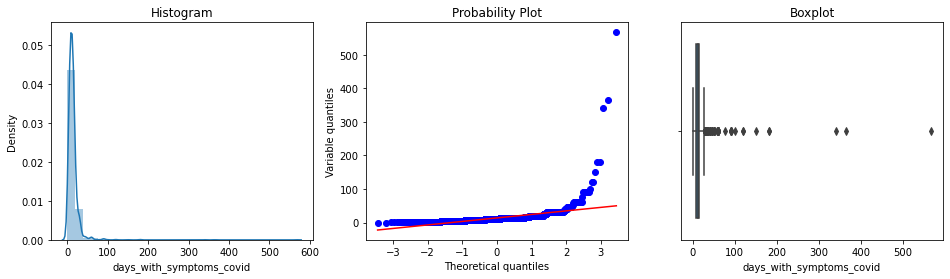

In [21]:
diagnostic_plots(data,num[0])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


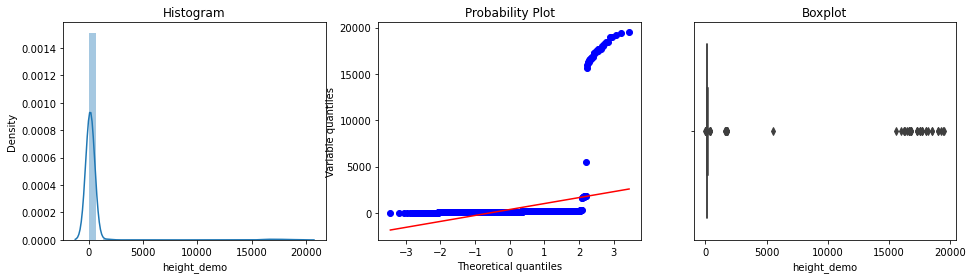

In [22]:
diagnostic_plots(data,num[1])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


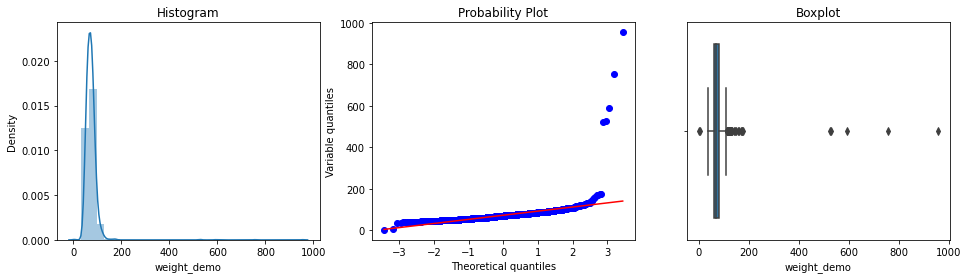

In [23]:
diagnostic_plots(data,num[2])

ok we must deal with outliers to obtain a normal distribution, additionally outliers can highly mess up k-means

In [24]:
def find_boundaries(df,variable,times):
    iqr=df[variable].quantile(0.75)-df[variable].quantile(0.25)
    lower=df[variable].quantile(0.25)-(iqr*times)
    upper=df[variable].quantile(0.75)+(iqr*times)
    return lower , upper 

def cap_outliers(df,variable,lower,upper):
    df[variable]=np.where(df[variable]>upper,upper,
                          np.where(df[variable]<lower,lower,df[variable]))
    

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


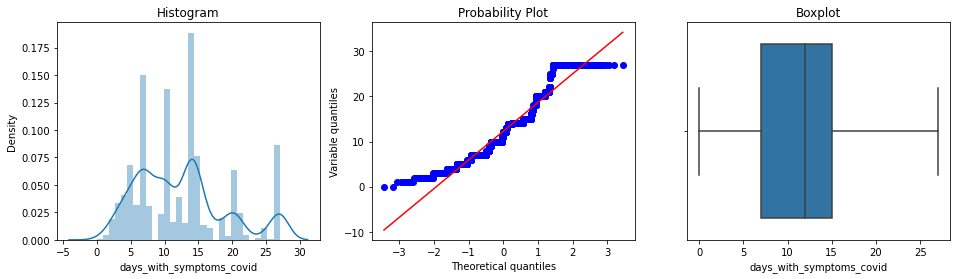

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


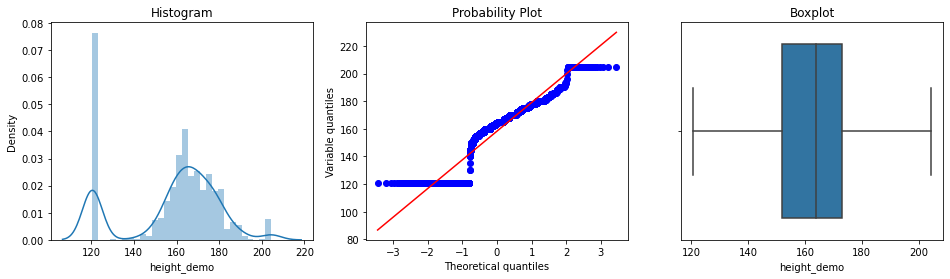

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


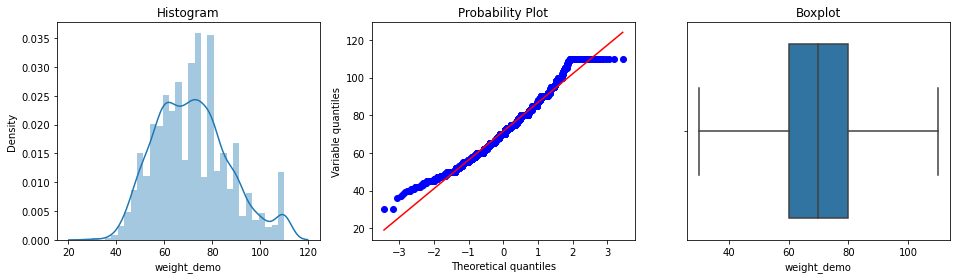

In [25]:
for col in num:
    lower,upper=find_boundaries(data,col,1.5)
    cap_outliers(data,col,lower,upper)
    diagnostic_plots(data,col)
    plt.show();

In [26]:
###scaling of data
##we will be using minmax scaling 


for col in num:
    data[col]=(data[col]-data[col].min())/(data[col].max()-data[col].min())

In [27]:
## calculating phq depression score
phq=[x for x in data.columns if "phq" in x ]
phq

['phq_0',
 'phq_1',
 'phq_2',
 'phq_3',
 'phq_4',
 'phq_5',
 'phq_6',
 'phq_7',
 'phq_8']

In [28]:
phq_map={'Not at all':0, 'Several days':1, 'More than half the days':2,
       'Nearly every day':3}
for p in phq:
    data.replace({p:phq_map},inplace=True)

In [29]:
data["phq_score"]=data[phq].sum(axis=1)
data.phq_score

0       22.0
1       15.0
2       11.0
3       13.0
4        0.0
        ... 
2565     0.0
2567    14.0
2568    13.0
2569    12.0
2570     9.0
Name: phq_score, Length: 2441, dtype: float64

In [30]:
for e,i in enumerate(data.phq_score):
    if i>=1 and i<=4:
        data.loc[e,"phq_score"]="minimal depression"
    elif i>=5 and i<=9:
        data.loc[e,"phq_score"]="mild depression"
    elif i>=10 and i<=14:
        data.loc[e,"phq_score"]="moderate depression"
    elif i>=15 and i<=19:
        data.loc[e,"phq_score"]="moderately severe depression"
    elif i>=20 and i<=27:
        data.loc[e,"phq_score"]="severe depression"
    else:
        data.loc[e,"phq_score"]="no depression"


In [31]:
for i in data.phq_score.value_counts().items():
    print(f"{i[0]} ( {i[1]} )  \t--> {i[1]/len(data)*100:.0f}%")

minimal depression ( 765 )  	--> 30%
mild depression ( 688 )  	--> 27%
no depression ( 513 )  	--> 20%
moderate depression ( 305 )  	--> 12%
moderately severe depression ( 119 )  	--> 5%
severe depression ( 51 )  	--> 2%
0.0 ( 27 )  	--> 1%
1.0 ( 16 )  	--> 1%
4.0 ( 10 )  	--> 0%
8.0 ( 9 )  	--> 0%
3.0 ( 8 )  	--> 0%
6.0 ( 8 )  	--> 0%
5.0 ( 6 )  	--> 0%
7.0 ( 6 )  	--> 0%
2.0 ( 6 )  	--> 0%
10.0 ( 4 )  	--> 0%
14.0 ( 4 )  	--> 0%
15.0 ( 3 )  	--> 0%
11.0 ( 3 )  	--> 0%
20.0 ( 2 )  	--> 0%
9.0 ( 2 )  	--> 0%
17.0 ( 2 )  	--> 0%
13.0 ( 2 )  	--> 0%
12.0 ( 2 )  	--> 0%
21.0 ( 1 )  	--> 0%
16.0 ( 1 )  	--> 0%
18.0 ( 1 )  	--> 0%


In [32]:
data.drop(phq,axis=1,inplace=True)


In [33]:
cat=[x for x in cat if x not in phq]
cat.append("phq_score")

## 2. Datetime Variables

In [43]:
#data.to_csv("checkpoint1.csv",index=False)
#data=pd.read_csv("checkpoint1.csv")
#num,cat,date,binary=detail_cols(data)

In [34]:
data.shape

(2564, 764)

In [35]:
data[date]

,date_tested_covid,symptoms_start_time_covid,form_filled_date_covid,vaccine_date_treatment,MEC_diagnosis_year_depaul
0,2021-01-14,2021-01-07,2021-11-21 22:10:42.557,2021-11-15,NaT
1,NaT,NaT,2021-11-26 22:35:28.161,NaT,NaT
2,NaT,2021-10-27,2021-11-27 07:22:40.949,2021-04-03,NaT
3,2021-08-23,2021-08-22,2021-11-27 14:14:40.847,2021-04-19,NaT
4,2021-08-16,2021-08-15,2021-11-27 14:51:23.895,2021-02-13,NaT
...,...,...,...,...,...
2290,NaT,NaT,NaT,NaT,NaT
2314,NaT,NaT,NaT,NaT,NaT
2366,NaT,NaT,NaT,NaT,NaT
2398,NaT,NaT,NaT,NaT,NaT


In [36]:
data[date].isna().sum()/len(data)

date_tested_covid            0.153666
symptoms_start_time_covid    0.140406
form_filled_date_covid       0.047972
vaccine_date_treatment       0.331903
MEC_diagnosis_year_depaul    0.963729
dtype: float64

In [37]:
#probably won't use these columns
data.drop(["MEC_diagnosis_year_depaul","form_filled_date_covid"],inplace=True,axis=1)

In [38]:
date.remove("MEC_diagnosis_year_depaul")
date.remove("form_filled_date_covid")

In [39]:
## how many person actually too the vaccine:
data.vaccine_treatment.value_counts()

Yes    1849
No      570
Name: vaccine_treatment, dtype: int64

In [40]:
data[date].isna().sum()/len(data)

date_tested_covid            0.153666
symptoms_start_time_covid    0.140406
vaccine_date_treatment       0.331903
dtype: float64

Knowing that some patients were asymptomatic and that some patients did not take the vaccine, we can assume that vaccine_date_treatment and symptoms_start_time_covid are MNAR (missing not at random) whereas date tested covid is probably lost due to recall or any random factor and thus is MAR (missing at random)

In [41]:
## for MNAR data will do imputation with a missing indiactor after we finish engineering for the clustering model
##data[["vaccine_date_treatment","symptoms_start_time_covid"]].fillna("missing",inplace=True)

In [42]:
data.vaccine_date_treatment.dt.quarter

0       4.0
1       NaN
2       2.0
3       2.0
4       1.0
       ... 
2290    NaN
2314    NaN
2366    NaN
2398    NaN
2429    NaN
Name: vaccine_date_treatment, Length: 2564, dtype: float64

In [43]:

date_ext=date.copy()
for col in date:
    print(col)
    new_var1=f"{col}_year"
    new_var2=f"{col}_quarter"    
    new_var3=f"{col}_month"
    new_var4=f"{col}_day" 
    data[new_var1]=data[col].dt.year
    data[new_var2]=data[col].dt.quarter
    data[new_var3]=data[col].dt.month
    data[new_var4]=data[col].dt.day
    date_ext.append(new_var1)
    date_ext.append(new_var2)
    date_ext.append(new_var3)
    date_ext.append(new_var4)
    
                              

date_tested_covid
symptoms_start_time_covid
vaccine_date_treatment


In [44]:
data[date_ext].T

,0,1,2,3,4,5,6,7,8,10,...,2198,2202,2209,2211,2282,2290,2314,2366,2398,2429
date_tested_covid,2021-01-14 00:00:00,NaT,NaT,2021-08-23 00:00:00,2021-08-16 00:00:00,2021-11-27 00:00:00,2020-03-31 00:00:00,2021-03-25 00:00:00,2021-09-21 00:00:00,2020-12-12 00:00:00,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
symptoms_start_time_covid,2021-01-07 00:00:00,NaT,2021-10-27 00:00:00,2021-08-22 00:00:00,2021-08-15 00:00:00,2021-01-12 00:00:00,2020-03-31 00:00:00,2021-09-07 00:00:00,2021-09-16 00:00:00,2020-12-12 00:00:00,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
vaccine_date_treatment,2021-11-15 00:00:00,NaT,2021-04-03 00:00:00,2021-04-19 00:00:00,2021-02-13 00:00:00,2021-05-20 00:00:00,2020-05-29 00:00:00,2021-03-03 00:00:00,2021-05-10 00:00:00,2021-09-19 00:00:00,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
date_tested_covid_year,2021.0,NaT,NaN,2021.0,2021.0,2021.0,2020.0,2021.0,2021.0,2020.0,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
date_tested_covid_quarter,1.0,NaT,NaN,3.0,3.0,4.0,1.0,1.0,3.0,4.0,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
date_tested_covid_month,1.0,NaT,NaN,8.0,8.0,11.0,3.0,3.0,9.0,12.0,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
date_tested_covid_day,14.0,NaT,NaN,23.0,16.0,27.0,31.0,25.0,21.0,12.0,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
symptoms_start_time_covid_year,2021.0,NaT,2021.0,2021.0,2021.0,2021.0,2020.0,2021.0,2021.0,2020.0,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
symptoms_start_time_covid_quarter,1.0,NaT,4.0,3.0,3.0,1.0,1.0,3.0,3.0,4.0,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
symptoms_start_time_covid_month,1.0,NaT,10.0,8.0,8.0,1.0,3.0,9.0,9.0,12.0,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [45]:
years=[x for x in date_ext if "year" in x]
for y in years:
    print(data[y].value_counts(),"\n")

2021.0    1262
2020.0     513
2022.0     384
2019.0       8
1974.0       1
2000.0       1
2023.0       1
Name: date_tested_covid_year, dtype: int64 

2021.0    1255
2020.0     523
2022.0     413
2019.0      11
2023.0       1
2000.0       1
Name: symptoms_start_time_covid_year, dtype: int64 

2021.0    1523
2022.0     143
2020.0      42
2019.0       3
1999.0       1
1996.0       1
Name: vaccine_date_treatment_year, dtype: int64 



In [46]:
correct_years=[2019,2020,2021,2022]
for y in years:
    data[y]=np.where(data[y].isin(correct_years),data[y],np.nan)
    #data[y].fillna("missing",inplace=True)
for y in years:
    print(data[y].value_counts(),"\n")

2021.0    1262
2020.0     513
2022.0     384
2019.0       8
Name: date_tested_covid_year, dtype: int64 

2021.0    1255
2020.0     523
2022.0     413
2019.0      11
Name: symptoms_start_time_covid_year, dtype: int64 

2021.0    1523
2022.0     143
2020.0      42
2019.0       3
Name: vaccine_date_treatment_year, dtype: int64 



In [47]:
data2=data.copy()

In [48]:
for y,d in zip(years,date):
    print(y,d)
    data2[f"{d}_month"]=np.where(data2[y]==2022,data2[f"{d}_month"]+36,
                                np.where(data2[y]==2021,data2[f"{d}_month"]+24,
                                        np.where(data2[y]==2020,data2[f"{d}_month"]+12,
                                                np.where(data2[y]==2019,data2[f"{d}_month"],np.nan))))
    data2[f"{d}_quarter"]=np.where(data2[y]==2022,data2[f"{d}_quarter"]+12,
                                np.where(data2[y]==2021,data2[f"{d}_quarter"]+8,
                                        np.where(data2[y]==2020,data2[f"{d}_quarter"]+4,
                                                np.where(data2[y]==2019,data2[f"{d}_quarter"],np.nan))))
    data2[f"{d}_day"]=np.where(data2[y]==2022,data2[f"{d}_day"]+1095,
                                np.where(data2[y]==2021,data2[f"{d}_day"]+730,
                                        np.where(data2[y]==2020,data2[f"{d}_day"]+365,
                                                np.where(data2[y]==2019,data2[f"{d}_day"],np.nan))))

date_tested_covid_year date_tested_covid
symptoms_start_time_covid_year symptoms_start_time_covid
vaccine_date_treatment_year vaccine_date_treatment


<Figure size 2160x720 with 0 Axes>

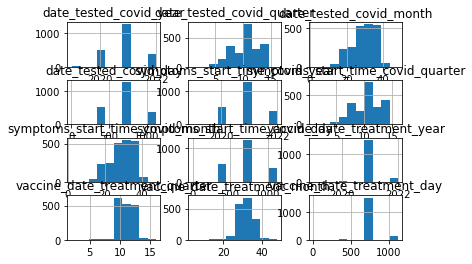

In [49]:
plt.figure(figsize=(30,10))
data2[date_ext[3:]].hist();

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='symptoms_start_time_covid_month', ylabel='Density'>

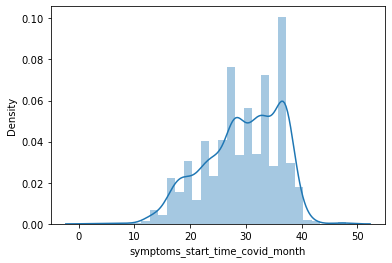

In [50]:
sns.distplot(data2["symptoms_start_time_covid_month"])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='vaccine_date_treatment_month', ylabel='Density'>

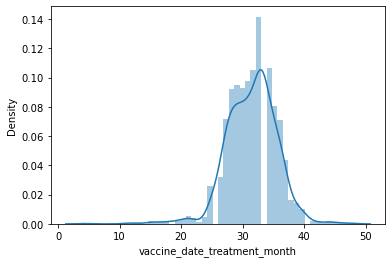

In [51]:
sns.distplot(data2["vaccine_date_treatment_month"])

date_tested and symptoms start seem to have the same distribution , we will only take symptoms start date month and vacccine treatment month for now and scale them for now

In [52]:
date_tobeused=["vaccine_date_treatment_month","symptoms_start_time_covid_month"]
for col in date_tobeused:
    data2[col]=(data2[col]-data2[col].min())/(data2[col].max()-data2[col].min())

In [53]:
not_used=[x for x in date_ext if x not in date_tobeused]
data2.drop(not_used,inplace=True,axis=1)

In [54]:
data2[date_tobeused].isna().sum()/len(data2)

vaccine_date_treatment_month       0.332683
symptoms_start_time_covid_month    0.141186
dtype: float64

as that both variables are MNAR we will used end of tail imputation  

In [55]:
from feature_engine.imputation import EndTailImputer
tail_imputer = EndTailImputer(imputation_method='gaussian',
                          tail='right',
                          fold=3,
                          variables=date_tobeused)
tail_imputer.fit(data2)

# transform the data
data3= tail_imputer.transform(data2)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='symptoms_start_time_covid_month', ylabel='Density'>

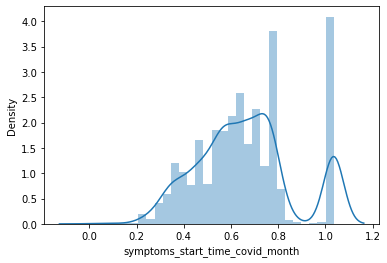

In [56]:
sns.distplot(data3["symptoms_start_time_covid_month"])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='vaccine_date_treatment_month', ylabel='Density'>

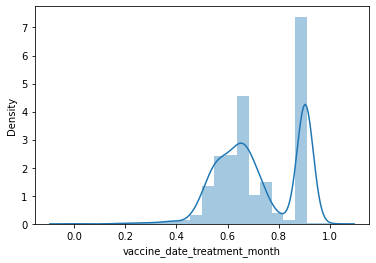

In [57]:
sns.distplot(data3["vaccine_date_treatment_month"])

## Categorical Variables

In [58]:
cat2=cat.copy()
ordinal2=ordinal.copy()

In [59]:
len(ordinal2),len(cat2)

(30, 56)

In [60]:
data3.drop(["pre-existing conditions_covid","OTC_prescription_alternate_use_treatment"],axis=1,inplace=True)
cat2.remove("pre-existing conditions_covid")
cat2.remove("OTC_prescription_alternate_use_treatment")

In [61]:
cat2.remove("city/state_demo")

In [62]:
### will try reducing cardinality of  categorical variables then perfrom onehotencoding or label encoding 
### perfrom PCA 
### build baseline clustering alogorithm



In [63]:
##data2.to_csv("checkpoint2.csv")
##data3.to_csv("checkpoint3.csv")

In [64]:
data3[cat2]

,other_1,other_43,other_53,mos_28,mos_29,mos_30,mos_31,mos_32,mos_33,mos_34,...,ancestry_demo,income_sources_demo,education_highest_demo,work_status_demo,persistent_fatigue_depaul,headaches_depaul,fatigue_duration_depaul,diagnosis_type_depaul,diagnosis_by_depaul,phq_score
0,NaN,Excellent,NaN,Excellent .......................................,Somewhat worse now than one year ago ............,"Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All","Yes, Limited A Little","No, Not Limited At All",...," Middle Eastern, North African (Lebanese, Ira..."," Less than $10,000", Standard college degree, Working full-time,No,NaN,NaN,NaN,NaN,severe depression
1,After COVID-19 infection,Fair,continuous,Good ............................................,Much better than one year ago ...................,"No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All",...," Asian, South Asian, southeast Asian (Chinese..."," Less than $10,000", Partial college (at least one year) or speci..., Student,No,NaN,NaN,NaN,NaN,moderately severe depression
2,Unrelated to COVID,Very good,NaN,Very good .......................................,About the same as one year ago ..................,"Yes, Limited A Little","Yes, Limited A Lot","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All",...," Asian, South Asian, southeast Asian (Chinese..."," $10,000 to less than $20,000", Graduate professional degree including maste..., Student,Not having a problem with fatigue/energy,NaN,NaN,NaN,NaN,moderate depression
3,Unrelated to COVID,Good,occasional,Good ............................................,Somewhat worse now than one year ago ............,"Yes, Limited A Lot","Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All",...," Asian, South Asian, southeast Asian (Chinese..."," Less than $10,000", High school degree or GED, Student,No,NaN,NaN,NaN,NaN,moderate depression
4,After COVID-19 infection,Excellent,NaN,Very good .......................................,Much better than one year ago ...................,"Yes, Limited A Little","Yes, Limited A Little","No, Not Limited At All","Yes, Limited A Little","No, Not Limited At All",...," Asian, South Asian, southeast Asian (Chinese..."," $10,000 to less than $20,000", Graduate professional degree including maste..., Working full-time,No,NaN,NaN,NaN,NaN,no depression
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,minimal depression
2314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mild depression
2366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no depression
2398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,minimal depression


In [65]:
data3.dropna(subset="PatientID",inplace=True)

In [66]:
for k,v in zip(data3[cat2].isna().keys(),data3[cat2].isna().sum().values):
    v=v/len(data3)*100
    if v>70:
        print(f"{k} dropped")
        data3.drop(k,axis=1,inplace=True)
        cat2.remove(k)

other_1 dropped
other_53 dropped
diagnosis_type_depaul dropped
diagnosis_by_depaul dropped


In [67]:
data3[cat2].isna().sum()/len(data3)

other_43                                  0.075789
mos_28                                    0.085211
mos_29                                    0.087259
mos_30                                    0.092175
mos_31                                    0.090537
mos_32                                    0.090537
mos_33                                    0.095862
mos_34                                    0.095043
mos_35                                    0.095453
mos_36                                    0.094633
mos_37                                    0.099959
mos_38                                    0.102007
mos_39                                    0.094633
mos_47                                    0.108972
mos_48                                    0.113068
mos_49                                    0.110610
mos_50                                    0.120442
mos_51                                    0.105694
mos_52                                    0.111020
mos_53                         

In [68]:
for col in cat:
    if "mos" in col:
        ordinal2.append(col)
        cat2.remove(col)

In [69]:
cat2.remove("other_43")
ordinal2.append("other_43")

In [70]:
dimensions_added=0
for i in cat2:
    cardinality=data3[i].nunique()
    print(f" Cardinality of {i} is {cardinality}")
    dimensions_added+=cardinality
    print(f"{i} unique values are {data3[i].unique()}\n")
print(f" \ndimnesions added if all was onehotencoded = {dimensions_added - len(cat2)}")

 Cardinality of test_type_covid is 6
test_type_covid unique values are ['Clinical symptoms' 'Nasal swab (PCR test)' 'Chest CT scan'
 'Spit test (PCR test)'
 'Swab or spit RAPID test (results within a couple of hours)' "Don't know"
 nan]

 Cardinality of consultant_type_covid is 15
consultant_type_covid unique values are ['My primary care doctor/General practitioner'
 'Alternative Medicine doctor' 'I have not seen any physician'
 'Pulmonologist' 'Hospitalist' 'Gastroenterologist' nan
 'Infectious disease specialist' 'Cardiologist' 'Immunologist/Allergist'
 'Rheumatologist' 'Hematologist' 'Neurologist/Neuroimmunologist'
 'Psychiatrist' 'Dermatologist' 'Obstetrician-Gynecologist (OB-GYN)']

 Cardinality of change in pre-exsiting condition_covid is 4
change in pre-exsiting condition_covid unique values are ['\uf071 No, they stayed the same.'
 '\uf071 N/A (I did not have any pre-existing condition)'
 '\uf071 Yes, they got better.' '\uf071 Yes, they got worse.' nan]

 Cardinality of smoker_c

In [71]:
data3.shape

(2441, 755)

In [74]:
from tqdm import tqdm
data_expanded=data3.copy()
for col in tqdm(cat2):
    try:
        temp=pd.get_dummies(data_expanded[col])
        data_expanded=pd.concat([data_expanded,temp],axis=1)
        #print(data_expanded.shape)
        data_expanded.drop(col,axis=1,inplace=True)
    except:
        print(f" {col} {data_expanded[col].unique()}\n")
data_expanded.shape

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 59.82it/s]


(2441, 892)

In [75]:
data_expanded[ordinal2]

,other_50,depaul_0,depaul_1,depaul_2,depaul_3,depaul_4,depaul_5,depaul_6,depaul_7,depaul_8,...,mos_55,mos_56,mos_57,mos_58,mos_59,mos_60,mos_61,mos_62,mos_63,other_43
0,NaN,2.0,2.0,1.0,1.0,1.0,1.0,4.0,3.0,2.0,...,Most of the Time,All of the Time,None of the Time,All of the Time,All of the time .................................,Definitely False,Mostly True,Don’t Know,Don’t Know,Excellent
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,A Good Bit of the Time,A Good Bit of the Time,Some of the Time,A Little of the Time,Some of the time ................................,Don’t Know,Definitely False,Don’t Know,Mostly False,Fair
2,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,Some of the Time,A Little of the Time,Some of the Time,Some of the Time,Some of the time ................................,Mostly True,Mostly True,Definitely False,Mostly True,Very good
3,1.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,...,A Good Bit of the Time,A Good Bit of the Time,A Good Bit of the Time,Some of the Time,Most of the time ................................,Don’t Know,Mostly False,Don’t Know,Don’t Know,Good
4,6.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,...,A Little of the Time,A Little of the Time,Most of the Time,Some of the Time,None of the time ................................,Definitely False,Definitely True,Definitely False,Mostly True,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,...,None of the Time,None of the Time,Most of the Time,None of the Time,None of the time ................................,Definitely False,Definitely True,Definitely False,Definitely True,Very good
2567,5.0,3.0,2.0,1.0,1.0,3.0,3.0,4.0,2.0,2.0,...,Most of the Time,Some of the Time,A Little of the Time,Some of the Time,Some of the time ................................,Definitely True,Mostly False,Mostly True,Mostly False,Good
2568,7.0,2.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,4.0,...,Some of the Time,Some of the Time,A Little of the Time,Most of the Time,Some of the time ................................,Mostly True,Mostly False,Definitely True,Mostly False,Good
2569,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,...,Some of the Time,Some of the Time,Most of the Time,A Good Bit of the Time,Some of the time ................................,Don’t Know,Mostly True,Don’t Know,Mostly True,Excellent


In [109]:
values_same_coding=[]
cols_found=[]
for i in range(len(ordinal2)):
    col1=ordinal2[i]
    flag=0
    cols_same_coding=[col1]
    for j in range(i+1,len(ordinal2)):
        col2=ordinal2[j]
        if col2 in cols_found:
            continue
        elif set(data4[col1].unique())==set(data4[col2].unique()):
            cols_same_coding.append(col2)
            flag=1
            if col2 not in cols_found:
                cols_found.append(col2)
    if len(cols_same_coding)>1:
        print(cols_same_coding)
            
            

['mos_30', 'mos_31', 'mos_32', 'mos_33', 'mos_34', 'mos_35', 'mos_36', 'mos_37', 'mos_38', 'mos_39']
['mos_47', 'mos_49']
['mos_50', 'mos_51', 'mos_52', 'mos_53', 'mos_54', 'mos_55', 'mos_56', 'mos_57', 'mos_58']
['mos_60', 'mos_61', 'mos_62', 'mos_63']


In [110]:
same1=['mos_30', 'mos_31', 'mos_32', 'mos_33', 'mos_34', 'mos_35', 'mos_36', 'mos_37', 'mos_38', 'mos_39']
same2=['mos_47', 'mos_49']
same3=['mos_50', 'mos_51', 'mos_52', 'mos_53', 'mos_54', 'mos_55', 'mos_56', 'mos_57', 'mos_58']
same4=['mos_60', 'mos_61', 'mos_62', 'mos_63']

In [115]:
data4[same1]

,mos_30,mos_31,mos_32,mos_33,mos_34,mos_35,mos_36,mos_37,mos_38,mos_39
0,"Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All","Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All"
1,"No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All"
2,"Yes, Limited A Little","Yes, Limited A Lot","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All"
3,"Yes, Limited A Lot","Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","Yes, Limited A Little","Yes, Limited A Lot","No, Not Limited At All","No, Not Limited At All"
4,"Yes, Limited A Little","Yes, Limited A Little","No, Not Limited At All","Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All","Yes, Limited A Little","Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All"
...,...,...,...,...,...,...,...,...,...,...
2565,"No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All"
2567,"Yes, Limited A Lot","Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","Yes, Limited A Lot","Yes, Limited A Little","Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All"
2568,"Yes, Limited A Lot","Yes, Limited A Little","Yes, Limited A Little","Yes, Limited A Little","Yes, Limited A Little","Yes, Limited A Lot","Yes, Limited A Little","Yes, Limited A Little","Yes, Limited A Little","Yes, Limited A Little"
2569,"Yes, Limited A Little","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All","No, Not Limited At All"


In [123]:
data4[same1[0]].value_counts().keys()

Index(['No, Not Limited At All', 'Yes, Limited  A Little',
       'Yes, Limited A Lot'],
      dtype='object')

In [129]:
rename_same1={'No, Not Limited At All':0, 'Yes, Limited  A Little':1,
       'Yes, Limited A Lot':2}
for col in same1:
    data4.replace({col:rename_same1},inplace=True)
data4[same1]

,mos_30,mos_31,mos_32,mos_33,mos_34,mos_35,mos_36,mos_37,mos_38,mos_39
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2567,2.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
2568,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
2569,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
data4[same2[1]].unique()

array(['Quite a bit .................................................................. 4',
       'Moderately ................................................................ 3',
       'Slightly ....................................................................... 2',
       'Not at all .................................................................... 1',
       nan,
       'Extremely .................................................................. 5'],
      dtype=object)

In [131]:
rename_same2={'Quite a bit .................................................................. 4':4,
       'Moderately ................................................................ 3':3,
       'Slightly ....................................................................... 2':2,
       'Not at all .................................................................... 1':1,
       'Extremely .................................................................. 5':5}
for col in same2:
    data4.replace({col:rename_same2},inplace=True)
data4[same2]

,mos_47,mos_49
0,5.0,4.0
1,2.0,3.0
2,4.0,2.0
3,3.0,4.0
4,1.0,1.0
...,...,...
2565,1.0,1.0
2567,2.0,3.0
2568,NaN,3.0
2569,2.0,4.0


In [132]:
data4[same3[1]].unique()

array(['All of the Time', 'None of the Time', 'Most of the Time',
       'A Little of the Time', 'A Good Bit of the Time', nan,
       'Some of the Time'], dtype=object)

In [133]:
rename_same3={'All of the Time':1, 'None of the Time':6, 'Most of the Time':2,
       'A Little of the Time':5, 'A Good Bit of the Time':3,
       'Some of the Time':4}
for col in same3:
    data4.replace({col:rename_same3},inplace=True)
data4[same3]

,mos_50,mos_51,mos_52,mos_53,mos_54,mos_55,mos_56,mos_57,mos_58
0,6.0,1.0,1.0,5.0,5.0,2.0,1.0,6.0,1.0
1,5.0,6.0,5.0,5.0,4.0,3.0,3.0,4.0,5.0
2,4.0,2.0,3.0,4.0,4.0,4.0,5.0,4.0,4.0
3,4.0,5.0,4.0,5.0,3.0,3.0,3.0,3.0,4.0
4,1.0,5.0,5.0,1.0,2.0,5.0,5.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...
2565,2.0,4.0,6.0,2.0,2.0,6.0,6.0,2.0,6.0
2567,3.0,2.0,2.0,5.0,4.0,2.0,4.0,5.0,4.0
2568,4.0,1.0,4.0,4.0,6.0,4.0,4.0,5.0,2.0
2569,6.0,5.0,4.0,2.0,5.0,4.0,4.0,2.0,3.0


In [134]:
data4[same4[1]].unique()

array(['Mostly True', 'Definitely False', 'Mostly False',
       'Definitely True', nan, 'Don’t Know'], dtype=object)

In [135]:
rename_same4={'Mostly True':2, 'Definitely False':5, 'Mostly False':4,
       'Definitely True':1, 'Don’t Know':3}
for col in same4:
    data4.replace({col:rename_same4},inplace=True)
data4[same4]

,mos_60,mos_61,mos_62,mos_63
0,5.0,2.0,3.0,3.0
1,3.0,5.0,3.0,4.0
2,2.0,2.0,5.0,2.0
3,3.0,4.0,3.0,3.0
4,5.0,1.0,5.0,2.0
...,...,...,...,...
2565,5.0,1.0,5.0,1.0
2567,1.0,4.0,2.0,4.0
2568,2.0,4.0,1.0,4.0
2569,3.0,2.0,3.0,2.0


In [146]:
solved=[]
solved.extend(same1)
solved.extend(same2)
solved.extend(same3)
solved.extend(same4)
ordinal3=[o for o in ordinal2 if o not in solved]
ordinal_unsolved=ordinal3.copy()
for col in ordinal3:
    if pd.api.types.is_numeric_dtype(data4[col]):
        ordinal_unsolved.remove(col)
data4[ordinal_unsolved]

,mos_28,mos_29,mos_48,mos_59,other_43
0,Excellent .......................................,Somewhat worse now than one year ago ............,Mild ............................................,All of the time .................................,Excellent
1,Good ............................................,Much better than one year ago ...................,Mild ............................................,Some of the time ................................,Fair
2,Very good .......................................,About the same as one year ago ..................,Mild ............................................,Some of the time ................................,Very good
3,Good ............................................,Somewhat worse now than one year ago ............,Moderate ........................................,Most of the time ................................,Good
4,Very good .......................................,Much better than one year ago ...................,Very mild .......................................,None of the time ................................,Excellent
...,...,...,...,...,...
2565,Excellent .......................................,About the same as one year ago ..................,None ............................................,None of the time ................................,Very good
2567,Good ............................................,About the same as one year ago ..................,Moderate ........................................,Some of the time ................................,Good
2568,Fair ............................................,Much worse now than one year ago ................,Severe ..........................................,Some of the time ................................,Good
2569,Excellent .......................................,Somewhat worse now than one year ago ............,Moderate ........................................,Some of the time ................................,Excellent


In [148]:
for col in ordinal_unsolved:
    print(col,"\n")
    print(data4[col].unique())

mos_28 

['Excellent .................................................................... 1'
 'Good ......................................................................... 3'
 'Very good .................................................................. 2'
 'Fair ............................................................................ 4'
 nan
 'Poor ........................................................................... 5']
mos_29 

['Somewhat worse now than one year ago ................. 4'
 'Much better than one year ago ................................. 1'
 'About the same as one year ago .............................. 3' nan
 'Somewhat better now than one year ago ................. 2'
 'Much worse now than one year ago ......................... 5']
mos_48 

['Mild ............................................................................ 3'
 'Moderate ................................................................... 4'
 'Very mild .....................................

In [159]:
data5=data4.copy()
easy_ones=ordinal_unsolved[:-1]
for col in easy_ones:
    data5[col]=data5[col].apply(lambda x:str(x)[-1])
    data5[col]=np.where(data5[col]=="n",np.nan,data5[col])
    data5[col]=data5[col].astype(float)
data5[easy_ones]

,mos_28,mos_29,mos_48,mos_59
0,1.0,4.0,3.0,1.0
1,3.0,1.0,3.0,3.0
2,2.0,3.0,3.0,3.0
3,3.0,4.0,4.0,2.0
4,2.0,1.0,2.0,5.0
...,...,...,...,...
2565,1.0,3.0,1.0,5.0
2567,3.0,3.0,4.0,3.0
2568,4.0,5.0,5.0,3.0
2569,1.0,4.0,4.0,3.0


In [160]:
rename={'Excellent':5, 'Fair':2, 'Very good' :4,'Good':3,  'Poor':1}
data5.replace({"other_43":rename},inplace=True)
data5["other_43"]=data5["other_43"].astype(float)

In [161]:
data5["other_43"]

0       5.0
1       2.0
2       4.0
3       3.0
4       5.0
       ... 
2565    4.0
2567    3.0
2568    3.0
2569    5.0
2570    3.0
Name: other_43, Length: 2441, dtype: float64

In [172]:
for col in ordinal2:
    data5[col]=data5[col].fillna(0)

## Binary Columns

In [188]:
binary

['other_2',
 'other_4',
 'other_7',
 'other_9',
 'other_11',
 'other_13',
 'other_14',
 'other_17',
 'other_20',
 'other_24',
 'other_26',
 'other_28',
 'other_30',
 'other_33',
 'other_35',
 'other_37',
 'other_39',
 'other_41',
 'other_44',
 'other_45',
 'other_47',
 'other_48',
 'other_51',
 'other_52',
 'other_54',
 ' Acute myelitis_other_0',
 ' Autoimmune encephalitis _other_0',
 ' Blood clot_other_0',
 ' Bone problems. Arthritis _other_0',
 ' Costochondritis_other_0',
 ' Cranial nerve involvement_other_0',
 ' Encephalopathy_other_0',
 ' Epilepsy_other_0',
 ' Gastroesophageal reflux disease_other_0',
 ' Irritable bowel syndrome_other_0',
 ' Known case of epilepsy but long time no attach of seizure but developed provoked seizure with Covid infection due to the fever .   Also developed Decrease urination -Given  diagnosis of AKI due to rhabdomyolysis_other_0',
 ' Macular hole_other_0',
 ' Meningitis_other_0',
 ' Meningoencephalitis_other_0',
 ' Migraine_other_0',
 ' Motor Peripheral

In [189]:
### fillna of binary with 0 for dummy variables and "missing" for categorical 

In [212]:
cat_bin=[]
num_bin=[]
for col in tqdm(binary):
    if pd.api.types.is_object_dtype(data5[col]):
        data5[col]=data5[col].fillna("missing")
        cat_bin.append(col)
    elif pd.api.types.is_numeric_dtype(data5[col]):
        data5[col]=data5[col].fillna(0)
        num_bin.append(col)

100%|█████████████████████████████████████████| 669/669 [00:09<00:00, 70.50it/s]


In [213]:
s=data5.isna().sum()
s=s.sort_values(ascending=False)

In [214]:
s[:30]

city/state_demo                                 57
PatientID                                        0
previous_infection_covid                         0
mos_53                                           0
mos_54                                           0
mos_55                                           0
mos_56                                           0
mos_57                                           0
mos_58                                           0
mos_59                                           0
mos_60                                           0
mos_61                                           0
mos_62                                           0
mos_63                                           0
consultation_sought_covid                        0
mos_51                                           0
symptoms_persistance_covid                       0
days_with_symptoms_covid                         0
Acid Reflux Disease_covid                        0
Allergies of unknown origin_cov

In [215]:
data5.drop("city/state_demo",axis=1,inplace=True)

In [223]:
data6=data5.copy()

In [224]:
for col in tqdm(cat_bin):
    try:
        temp=pd.get_dummies(data6[col])
        data6=pd.concat([data6,temp],axis=1)
        #print(data_expanded.shape)
        data6.drop(col,axis=1,inplace=True)
    except:
        print(f" {col} {data6[col].unique()}\n")

100%|███████████████████████████████████████████| 43/43 [00:00<00:00, 68.43it/s]


In [225]:
##### end of notebook here 
data6.to_csv("checkpoint_final.csv")

In [226]:
data6.dtypes

PatientID                            float64
other_43                             float64
other_50                             float64
 Acute myelitis_other_0              float64
 Autoimmune encephalitis _other_0    float64
                                      ...   
Yes                                    uint8
missing                                uint8
No                                     uint8
Yes                                    uint8
missing                                uint8
Length: 975, dtype: object